# Phase 0: EDA 

### Basic Overview

In [2]:
import pandas as pd

df = pd.read_csv("./data/beijing.csv")

# Basic info
print("Shape: ", df.shape)
print("Dtypes:\n",df.dtypes)
print(df.head())

# Quick stats
print(df.describe())


Shape:  (39523, 20)
Dtypes:
 year             int64
month            int64
day              int64
hour             int64
zone             int64
city            object
longitude      float64
latitude       float64
aqi              int64
co             float64
no             float64
no2            float64
o3             float64
so2            float64
pm2_5          float64
pm10           float64
nh3            float64
temperature    float64
dewpt          float64
date            object
dtype: object
   year  month  day  hour  zone     city  longitude  latitude  aqi       co  \
0  2020     11   25     1    46  Beijing   116.3913   39.9062    5  3952.03   
1  2020     11   25     2    46  Beijing   116.3913   39.9062    5  3417.97   
2  2020     11   25     3    46  Beijing   116.3913   39.9062    5  2429.96   
3  2020     11   25     4    46  Beijing   116.3913   39.9062    5   674.25   
4  2020     11   25     5    46  Beijing   116.3913   39.9062    5   554.09   

       no     no2     

### Missing Values Heatmap

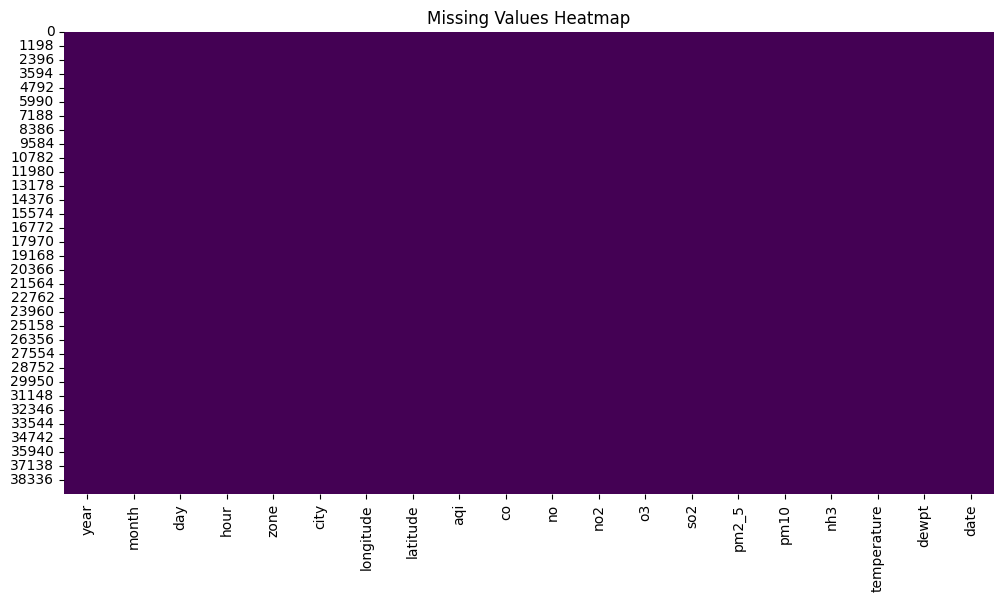

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


### Histograms of Key Variables

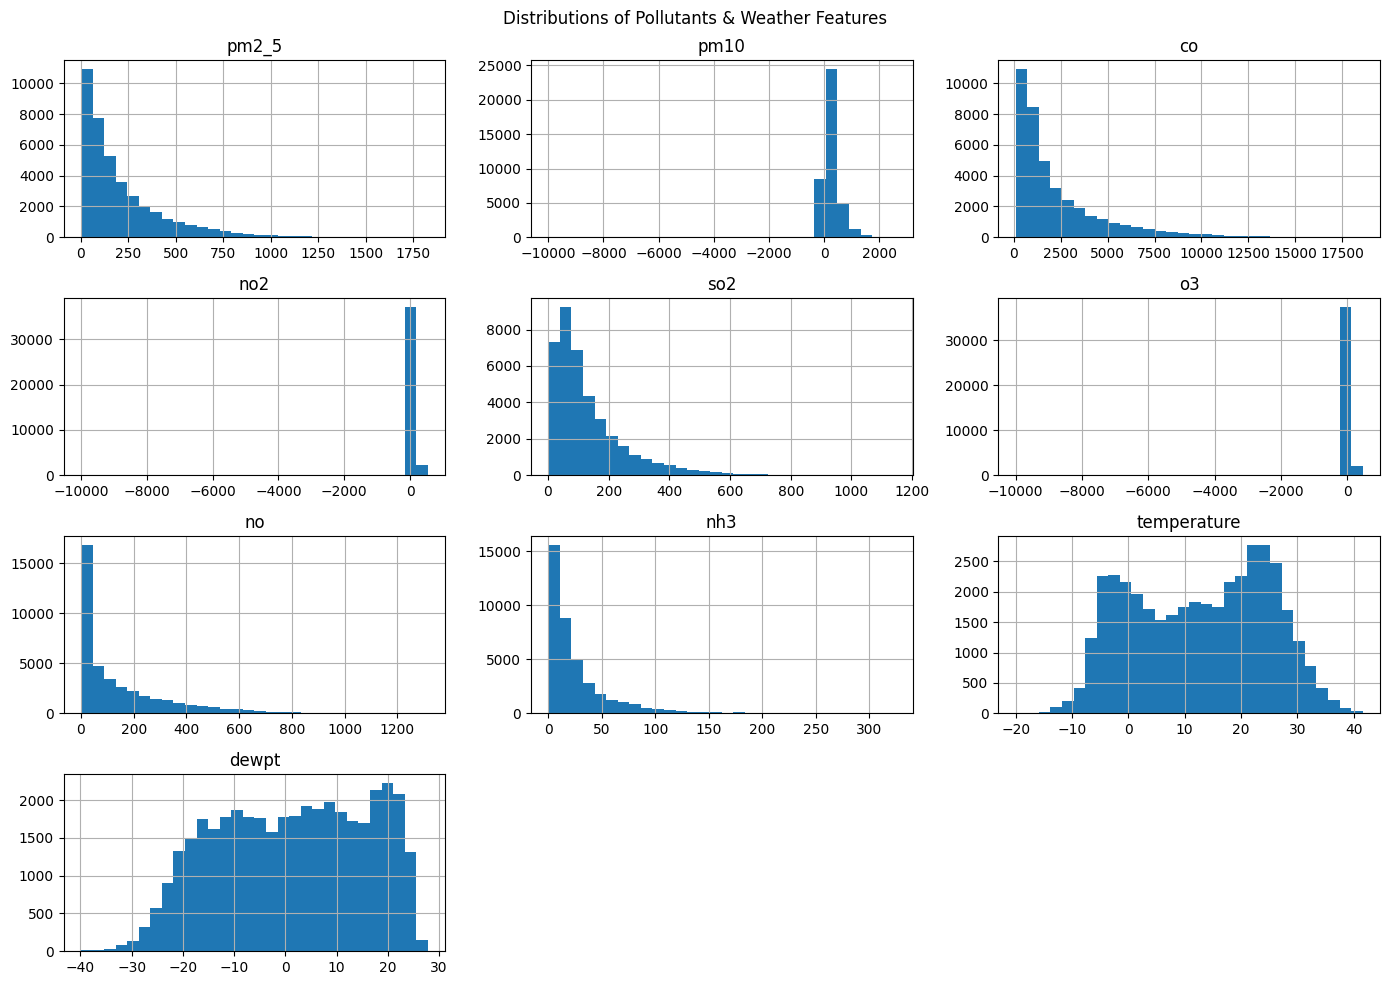

In [4]:
pollutants = ['pm2_5', 'pm10', 'co', 'no2', 'so2', 'o3', 'no', 'nh3']
weather = ['temperature', 'dewpt']

df[pollutants + weather].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distributions of Pollutants & Weather Features")
plt.tight_layout()
plt.show()


### Time Series Plots

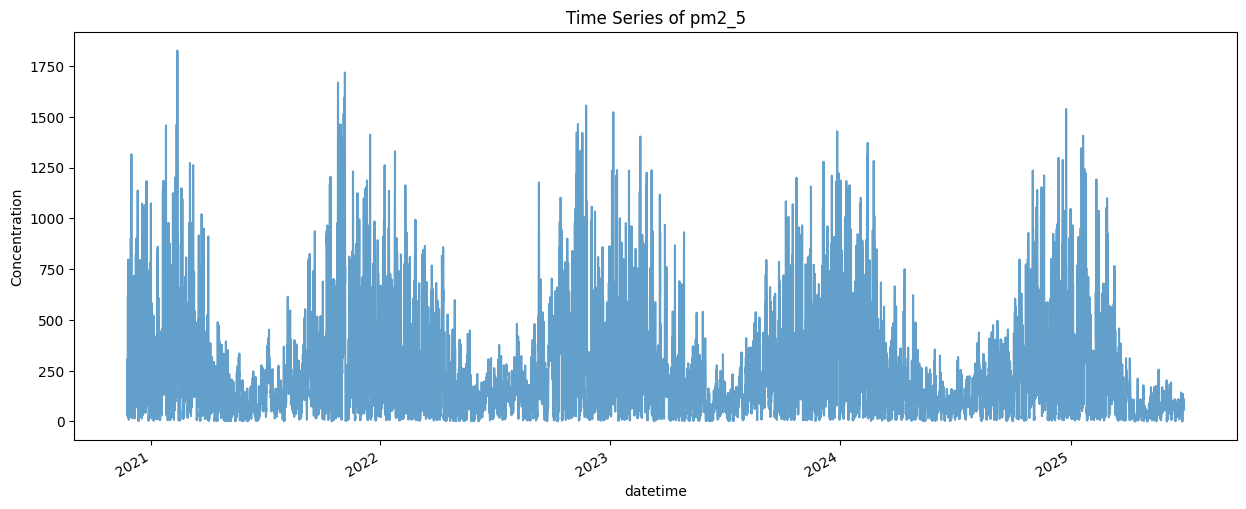

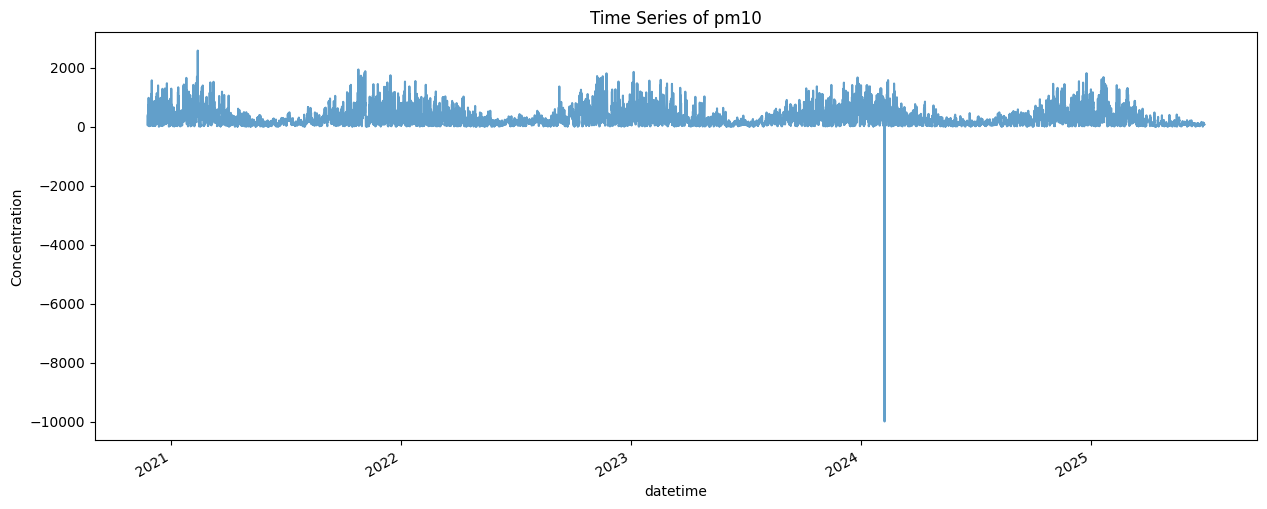

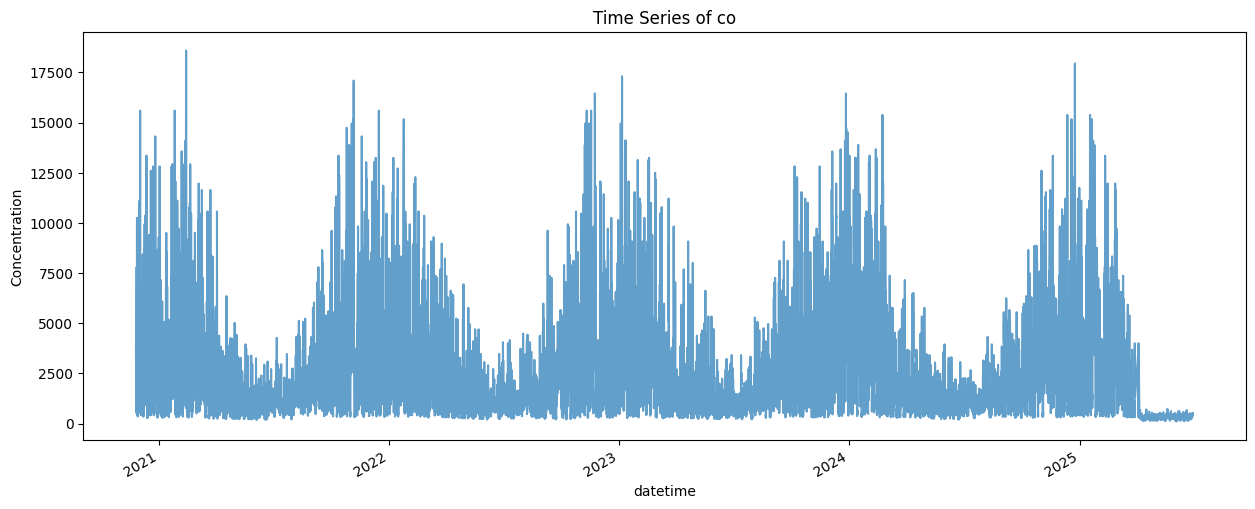

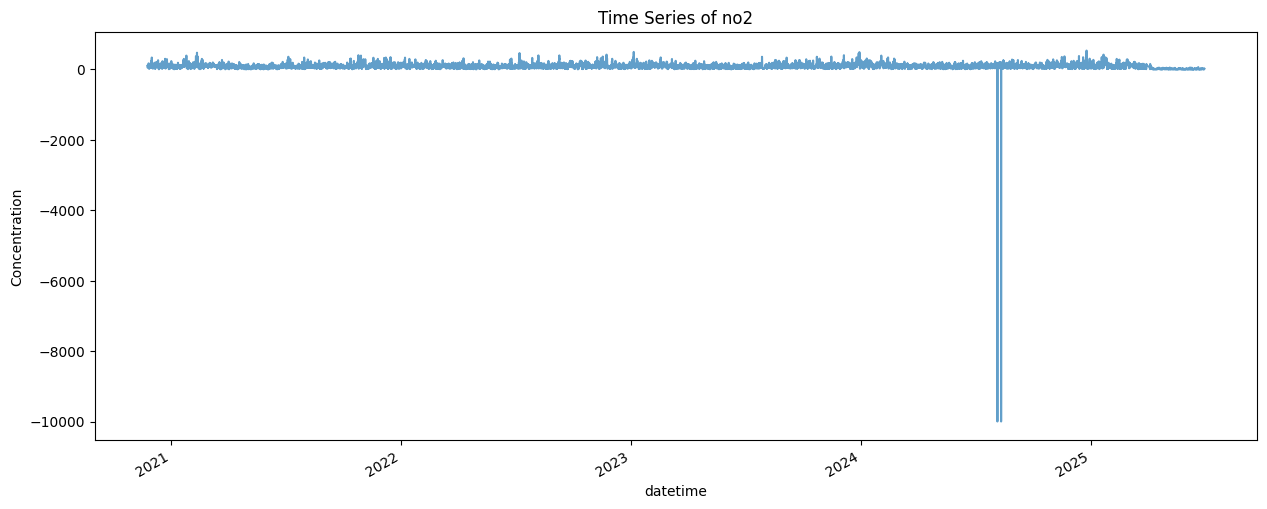

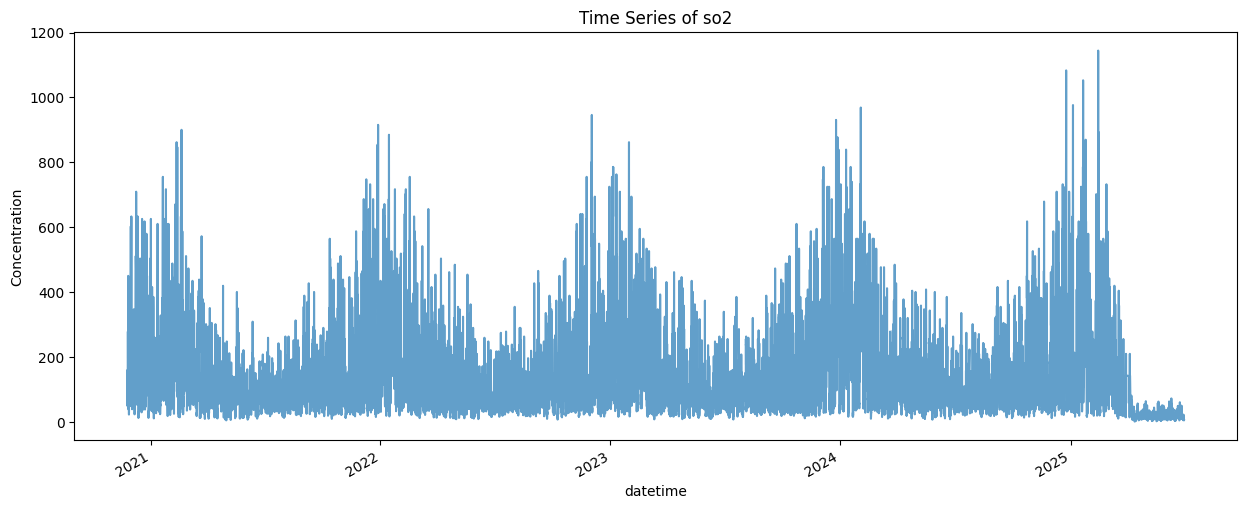

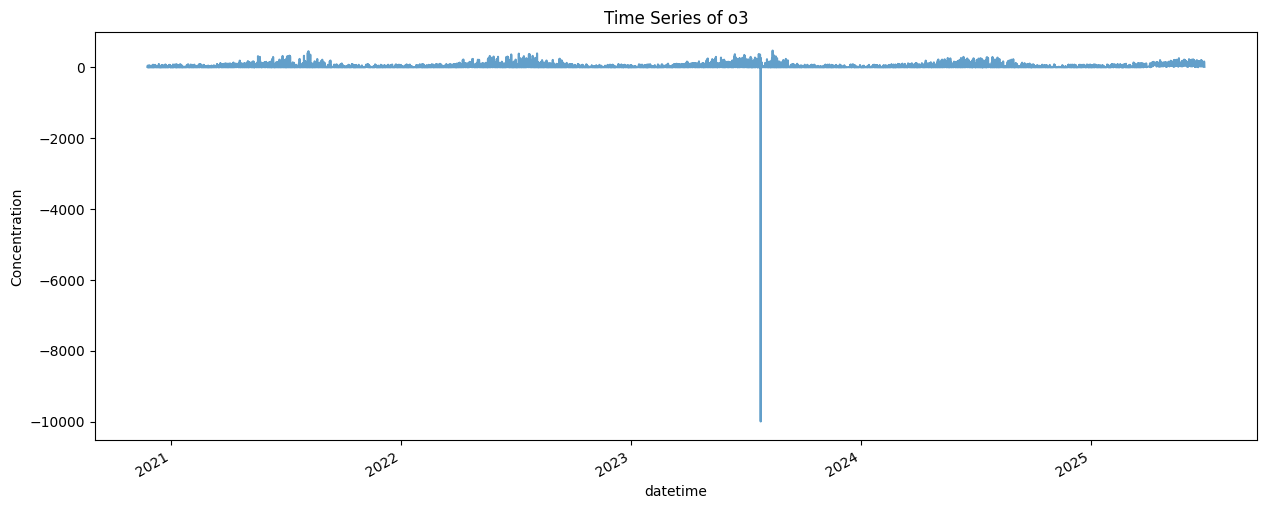

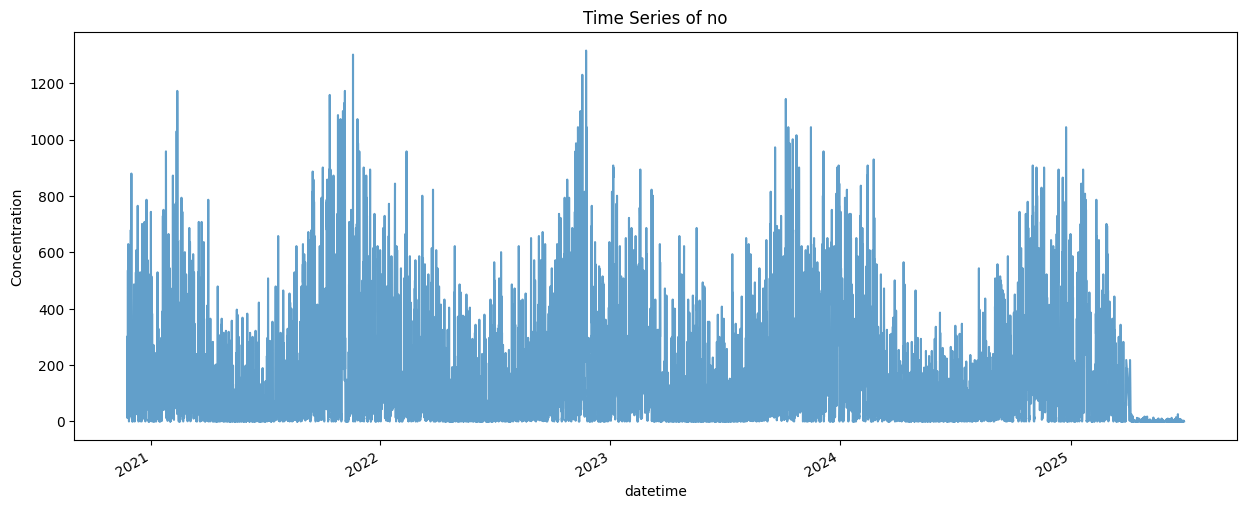

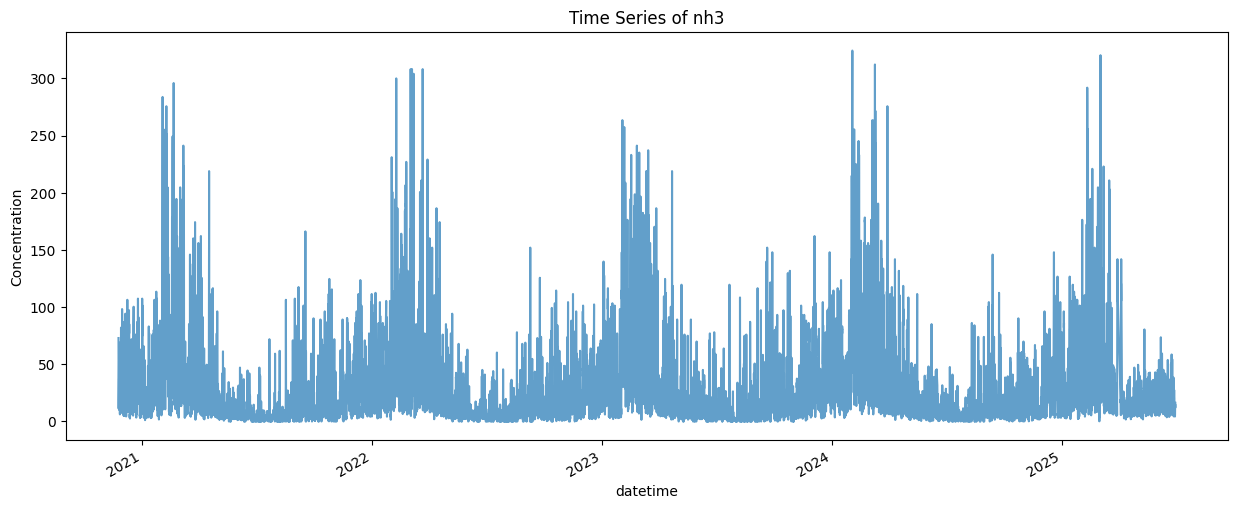

In [154]:
# Parse datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

for pollutant in pollutants:
# Plot pollutants over time
    df[pollutant].plot(figsize=(15, 6), alpha=0.7)
    plt.title(f"Time Series of {pollutant}")
    plt.ylabel("Concentration")
    plt.show()


### Correlation Heatmap

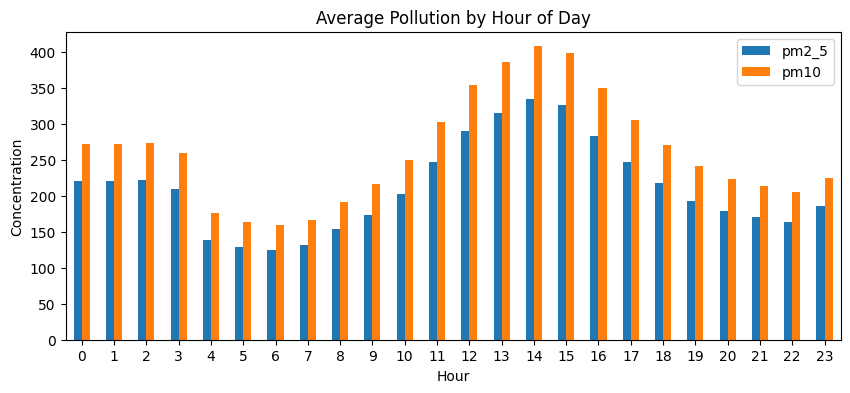

In [156]:
# Hourly average pollution
hourly_avg = df.groupby(df.index.hour)[['pm2_5', 'pm10']].mean()

hourly_avg.plot(kind='bar', figsize=(10, 4))
plt.title("Average Pollution by Hour of Day")
plt.ylabel("Concentration")
plt.xlabel("Hour")
plt.xticks(rotation=0)
plt.show()


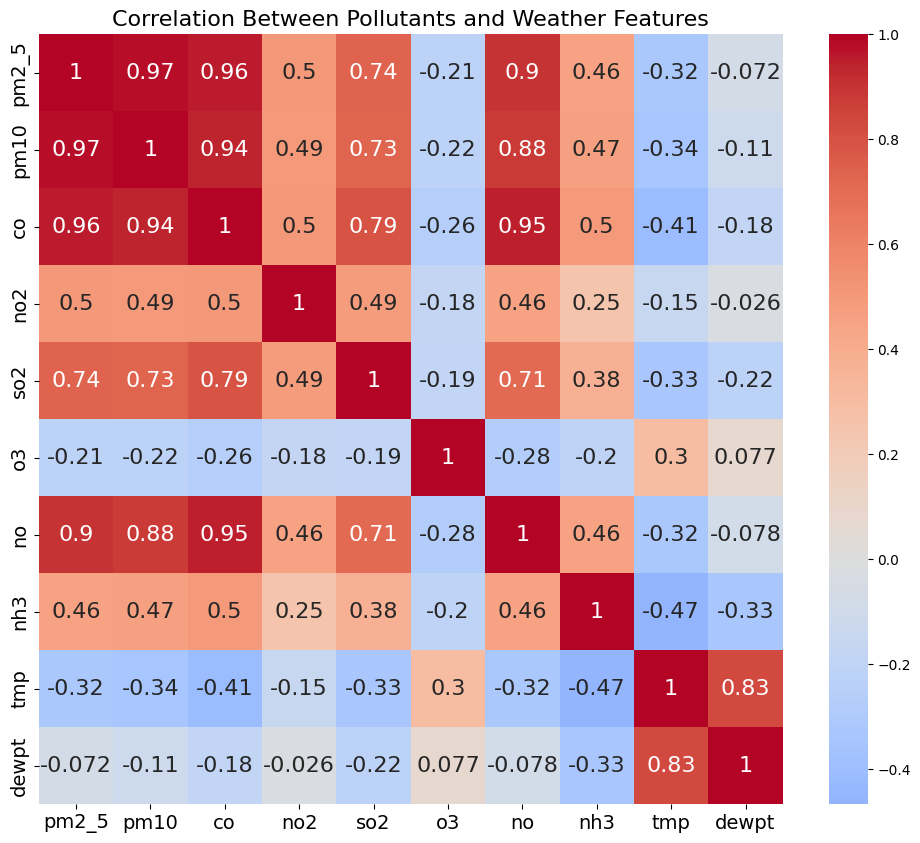

In [6]:
plt.figure(figsize=(12, 10))
corr = df[pollutants + weather].corr()

# rename columns and index only for plotting
corr = corr.rename(columns={"temperature": "tmp"}, index={"temperature": "tmp"})

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 16}
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Correlation Between Pollutants and Weather Features", fontsize=16)
plt.show()


# Phase 1: Data Preparation

### Load Data & Parse Datetime

In [157]:
# Load CSV
df = pd.read_csv("./data/beijing.csv")

# Combine year, month, day, hour into datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set datetime as index
df.set_index('datetime', inplace=True)

# Drop any redundant columns if desired
df.drop(columns=['year', 'month', 'day', 'hour', 'zone', 'city', 'longitude', 'latitude', 'date', 'aqi'], inplace=True)

# Sort by datetime
df = df.sort_index()

df.tail()


,co,no,no2,o3,so2,pm2_5,pm10,nh3,temperature,dewpt
datetime,,,,,,,,,,
2025-06-29 15:00:00,474.83,0.00,17.00,43.27,6.21,62.06,69.47,13.76,23.0,21.9
2025-06-29 16:00:00,480.46,0.00,17.84,31.00,5.06,62.20,69.60,12.63,22.6,21.8
2025-06-29 17:00:00,489.43,0.01,18.80,22.09,4.75,62.34,69.32,12.17,22.5,21.6
2025-06-29 18:00:00,500.19,0.02,20.09,15.62,4.99,63.12,69.68,12.01,22.3,21.5
2025-06-29 19:00:00,510.52,0.06,22.01,10.96,6.04,64.31,70.41,16.37,22.2,21.5


### Outlier Handling

In [158]:
from scipy.stats import zscore

# Z-score outlier removal for numeric columns
z_scores = df.apply(zscore)
df = df[(z_scores < 3).all(axis=1)]  # Keep only within 3 std dev

df.shape


(36830, 10)

### Cleanup and Scaling

In [159]:
# Standardize features
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Ready for modeling
df.to_csv("./data/beijing_preprocessed_unscaled.csv")


### Data Splitting

In [160]:
df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])

test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

# 1) How many validation rows?
n_total = len(df)
n_val   = int(n_total * 0.1)        # 10% of df_train_val
n_train = n_total - n_val          # the rest

# 2) Slice
df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val  = df_train_val.iloc[n_train:].reset_index(drop=True)

# 3) Sanity check
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))


Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830


# Phase 2: Feature Selection

### Mutual Information (MI)

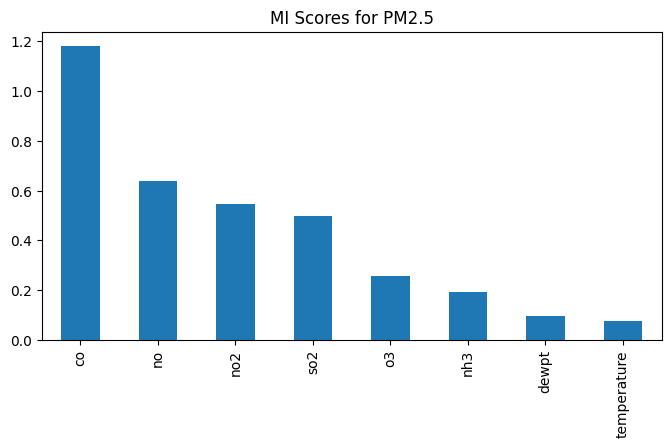

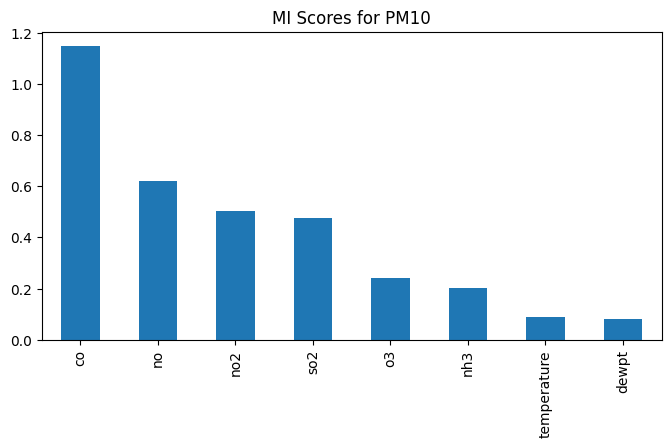

In [161]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import pandas as pd

# Load preprocessed dataset
#df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df_train
df.set_index('datetime', inplace=True)

features = ['co', 'no', 'no2', 'o3', 'so2', 'nh3', 'temperature', 'dewpt']

X = df[features]
y_pm25 = df['pm2_5']
y_pm10 = df['pm10']

# Mutual Information for PM2.5
mi_pm25 = mutual_info_regression(X, y_pm25)
mi_scores_pm25 = pd.Series(mi_pm25, index=features).sort_values(ascending=False)

# Mutual Information for PM10
mi_pm10 = mutual_info_regression(X, y_pm10)
mi_scores_pm10 = pd.Series(mi_pm10, index=features).sort_values(ascending=False)

# Plot
mi_scores_pm25.plot(kind='bar', title="MI Scores for PM2.5", figsize=(8, 4))
plt.show()

mi_scores_pm10.plot(kind='bar', title="MI Scores for PM10", figsize=(8, 4))
plt.show()


### mRMR (Minimum Redundancy Maximum Relevance)

In [162]:
import pymrmr

# pymrmr requires all numerical data and no NaNs
df_mrmr = df[features + ['pm2_5', 'pm10']].dropna()
df_mrmr = df_mrmr.reset_index(drop=True)

# mRMR for PM2.5 (returns top 5 features)
mrmr_pm25 = pymrmr.mRMR(df_mrmr.rename(columns={'pm2_5': 'target'}), 'MIQ', 5)

# mRMR for PM10
mrmr_pm10 = pymrmr.mRMR(df_mrmr.rename(columns={'pm10': 'target'}), 'MIQ', 5)

print("Top mRMR Features for PM2.5:", mrmr_pm25)
print("Top mRMR Features for PM10:", mrmr_pm10)




 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 9 	 pm10 	 3.195
2 	 8 	 target 	 3.053
3 	 1 	 no 	 2.194
4 	 4 	 so2 	 1.854
5 	 2 	 no2 	 1.684

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 9 	 pm10 	 3.195
2 	 3 	 o3 	 0.941
3 	 1 	 no 	 1.214
4 	 2 	 no2 	 1.215
5 	 8 	 target 	 1.190


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: 

# PHASE 3: Forecasting with NeuralProphet (PM2.5 Target)

### Prepare Data

In [3]:
# Load and format data

df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Select features
features = ['pm2_5', 'pm10', 'no', 'no2', 'co', 'so2']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm2_5': 'y'})

test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

# 1) How many validation rows?
n_total = len(df)
n_val   = int(n_total * 0.1)        # 10% of df_train_val
n_train = n_total - n_val          # the rest

# 2) Slice
df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val  = df_train_val.iloc[n_train:].reset_index(drop=True)

# 3) Sanity check
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))


Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830


In [164]:
from sklearn.preprocessing import StandardScaler


# Identify feature columns to scale
feature_cols = [col for col in df_train.columns if col not in ['ds', 'y']]

# Initialize and fit the scaler
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Scale df_val
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

# Scale df_test
df_test[feature_cols] = scaler.transform(df_test[feature_cols])


### Initial training to determine autoregression lags

In [165]:
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm10', 'no', 'no2', 'co', 'so2']

# Declare model with regressors
model = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
)

model.set_plotting_backend("matplotlib")

model.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = model.fit(df, freq='H')

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/264 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 87. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



In [166]:
metrics.tail(1)

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
39,0.008854,0.0,29.188938,50.098194,0.008858,0.0,39


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

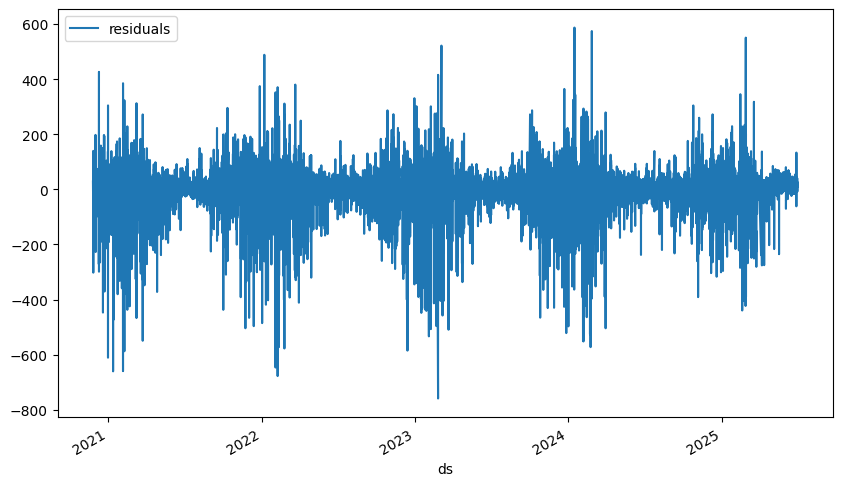

In [167]:
forecast = model.predict(df)
df_residuals = pd.DataFrame({"ds": df["ds"], "residuals": df["y"] - forecast["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

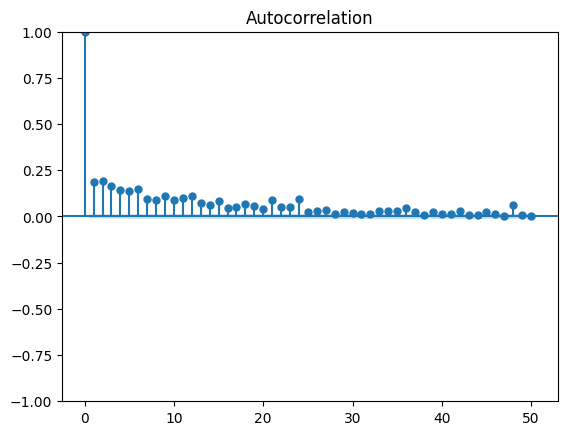

In [168]:
from statsmodels.graphics.tsaplots import plot_acf

plt = plot_acf(df_residuals["residuals"].dropna(), lags=50)

### Final Model Forecasting

In [169]:
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.utils import set_random_seed

set_random_seed(42)

set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm10', 'no', 'no2', 'co', 'so2']

# Declare model with regressors
pm2_5_model_np = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    #n_lags=5
)


In [170]:
pm2_5_model_np.set_plotting_backend("matplotlib")

pm2_5_model_np.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = pm2_5_model_np.fit(df_train, validation_df=df_val, freq='H', epochs=50)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():



WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [171]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
49,24.27964,41.895512,0.010462,0.0,49,0.009293,0.0,29.19906,51.981762,0.009293,0.0


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



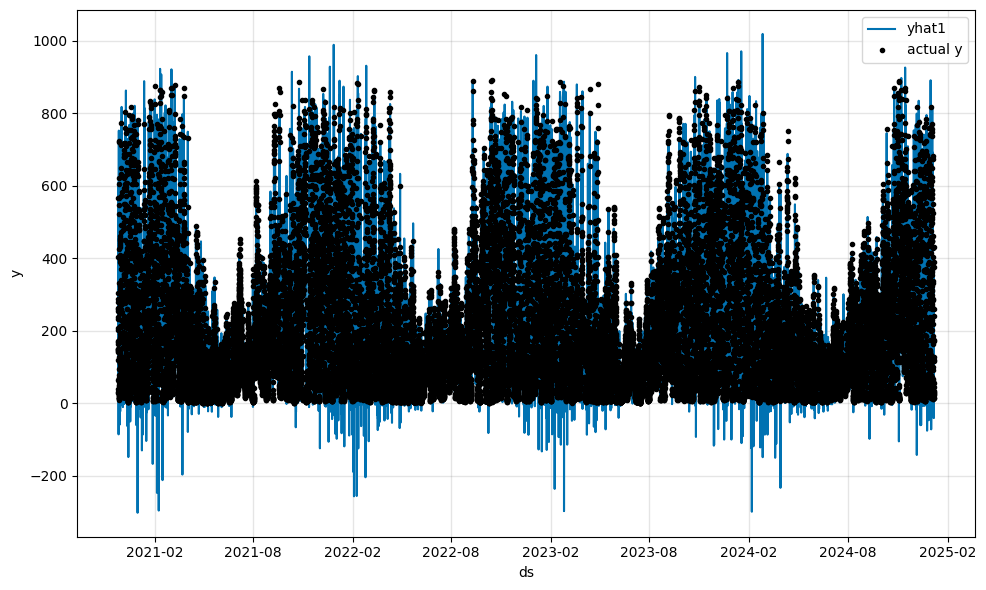

In [172]:
forecast = pm2_5_model_np.predict(df_train)
pm2_5_model_np.plot(forecast)

### Test Results

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

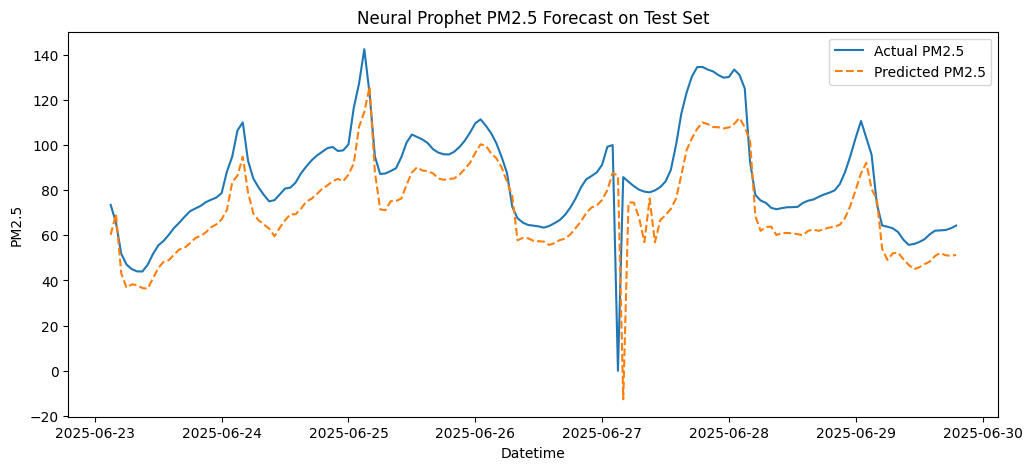

In [173]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm2_5_model_np.predict(df_test)

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat1']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat1'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM2.5')
plt.plot(cmp_test.index, cmp_test['yhat1'], label='Predicted PM2.5', linestyle='--')
plt.title("Neural Prophet PM2.5 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [174]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat1']

mae_np_pm2_5_test  = mean_absolute_error(y_true, y_pred)
rmse_np_pm2_5_test = root_mean_squared_error(y_true, y_pred)
r2_np_pm2_5_test   = r2_score(y_true, y_pred)

print(f"Neural Prophet PM2.5 Forecasting Test MAE:  {mae_np_pm2_5_test:.3f}")
print(f"Neural Prophet PM2.5 Forecasting Train RMSE: {rmse_np_pm2_5_test:.3f}")
print(f"Neural Prophet PM2.5 Forecasting Test R²:   {r2_np_pm2_5_test:.3f}")

Neural Prophet PM2.5 Forecasting Test MAE:  14.566
Neural Prophet PM2.5 Forecasting Train RMSE: 17.792
Neural Prophet PM2.5 Forecasting Test R²:   0.377


# PHASE 4: Forecasting with NeuralProphet (PM10 Target)

### Prepare Data

In [175]:
# Load and format data

df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Select features
features = ['pm2_5', 'pm10', 'no', 'no2', 'co', 'so2']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm10': 'y'})

test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

# 1) How many validation rows?
n_total = len(df)
n_val   = int(n_total * 0.1)        # 10% of df_train_val
n_train = n_total - n_val          # the rest

# 2) Slice
df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val  = df_train_val.iloc[n_train:].reset_index(drop=True)

# 3) Sanity check
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))

Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830


In [176]:
from sklearn.preprocessing import StandardScaler


# Identify feature columns to scale
feature_cols = [col for col in df_train.columns if col not in ['ds', 'y']]

# Initialize and fit the scaler
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Scale df_val
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

# Scale df_test
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

### Final Model Forecasting

In [177]:
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.utils import set_random_seed

set_random_seed(42)


set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm2_5','no', 'no2', 'co', 'so2']

# Declare model with regressors
pm10_model_np = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    #n_lags=5
)

In [178]:
pm10_model_np.set_plotting_backend("matplotlib")

pm10_model_np.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = pm10_model_np.fit(df_train, validation_df=df_val, freq='H', epochs=50)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [179]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
49,28.950575,50.306175,0.010504,0.0,49,0.008526,0.0,33.328201,60.40704,0.008526,0.0


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



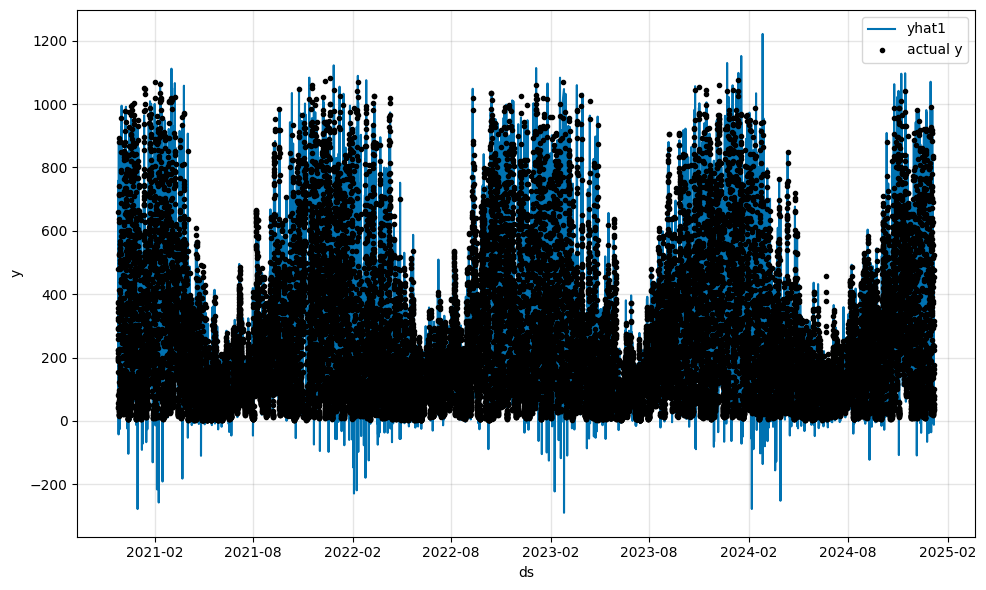

In [180]:
forecast = pm10_model_np.predict(df_train)
pm10_model_np.plot(forecast)

### Test Results

#### Prediction on 168 hours

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

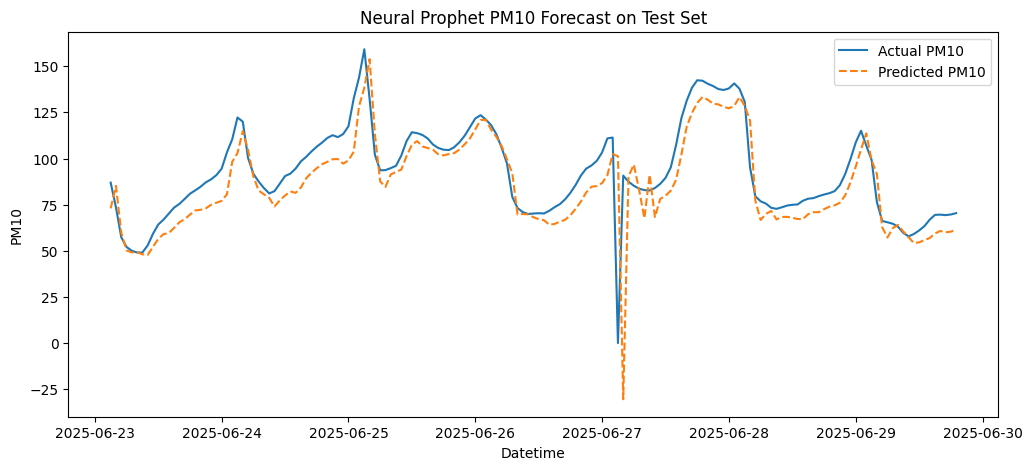

In [181]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm10_model_np.predict(df_test)

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat1']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat1'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM10')
plt.plot(cmp_test.index, cmp_test['yhat1'], label='Predicted PM10', linestyle='--')
plt.title("Neural Prophet PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [182]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat1']

mae_np_pm10_test  = mean_absolute_error(y_true, y_pred)
rmse_np_pm10_test = root_mean_squared_error(y_true, y_pred)
r2_np_pm10_test   = r2_score(y_true, y_pred)

print(f"Neural Prophet PM10 Forecasting Test MAE:  {mae_np_pm10_test:.3f}")
print(f"Neural Prophet PM10 Forecasting Test RMSE: {rmse_np_pm10_test:.3f}")
print(f"Neural Prophet PM10 Forecasting Test R²:   {r2_np_pm10_test:.3f}")

Neural Prophet PM10 Forecasting Test MAE:  10.011
Neural Prophet PM10 Forecasting Test RMSE: 16.118
Neural Prophet PM10 Forecasting Test R²:   0.564


#### Prediction on 24 hours

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

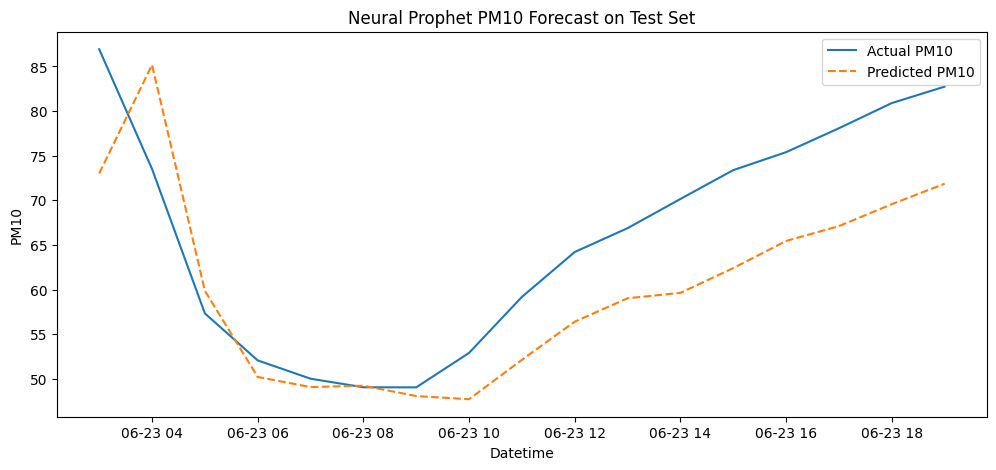

In [183]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm10_model_np.predict(df_test[:24])

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat1']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat1'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM10')
plt.plot(cmp_test.index, cmp_test['yhat1'], label='Predicted PM10', linestyle='--')
plt.title("Neural Prophet PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [184]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat1']

mae_np_pm10_test  = mean_absolute_error(y_true, y_pred)
rmse_np_pm10_test = root_mean_squared_error(y_true, y_pred)
r2_np_pm10_test   = r2_score(y_true, y_pred)

print(f"Neural Prophet PM10 Forecasting Test MAE:  {mae_np_pm10_test:.3f}")
print(f"Neural Prophet PM10 Forecasting Test RMSE: {rmse_np_pm10_test:.3f}")
print(f"Neural Prophet PM10 Forecasting Test R²:   {r2_np_pm10_test:.3f}")

Neural Prophet PM10 Forecasting Test MAE:  7.325
Neural Prophet PM10 Forecasting Test RMSE: 8.530
Neural Prophet PM10 Forecasting Test R²:   0.528


# FB Prophet (PM2.5 Target)

### Prepare Data

In [185]:
# Load and format data

df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Select features
features = ['pm10', 'pm2_5', 'no', 'no2', 'co', 'so2']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm2_5': 'y'})

test_hours = 24 * 7
df_train = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

n_total = len(df)

print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_test))

Total: 36830
Train rows: 36662
Test rows:   168
Sum check: 36830


In [186]:
from sklearn.preprocessing import StandardScaler


# Identify feature columns to scale
feature_cols = [col for col in df_train.columns if col not in ['ds', 'y']]

# Initialize and fit the scaler
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Scale df_val
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

# Scale df_test
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

KeyError: "['pm10'] not in index"

### Model Implementation

In [ ]:
from prophet import Prophet
import random
random.seed(1234)

# Define regressors
regressors = ['no', 'no2', 'co', 'so2', 'pm10']

# Initialize model
pm2_5_model_fbp = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add external regressors
for reg in regressors:
    pm2_5_model_fbp.add_regressor(reg)

In [ ]:
# Fit the model
pm2_5_model_fbp.fit(df_train)

02:09:16 - cmdstanpy - INFO - Chain [1] start processing
02:09:58 - cmdstanpy - INFO - Chain [1] done processing


### Training Results

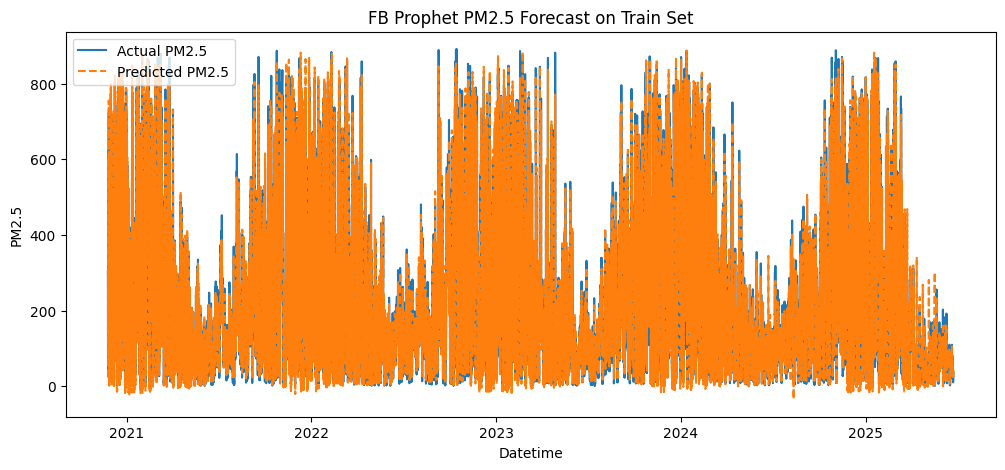

In [ ]:
import matplotlib.pyplot as plt

# 1) Predict on the train set
forecast_train = pm2_5_model_fbp.predict(df_train)
#forecast_test.columns

# 2) Build two Series indexed by ds
pred = forecast_train.set_index('ds')['yhat']
actual = df_train.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_train = actual.to_frame('y').join(pred.to_frame('yhat'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_train.index, cmp_train['y'],    label='Actual PM2.5')
plt.plot(cmp_train.index, cmp_train['yhat'], label='Predicted PM2.5', linestyle='--')
plt.title("FB Prophet PM2.5 Forecast on Train Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 5) Compute metrics
y_true = cmp_train['y']
y_pred = cmp_train['yhat']

mae_fbp_pm2_5_train  = mean_absolute_error(y_true, y_pred)
rmse_fbp_pm2_5_train = root_mean_squared_error(y_true, y_pred)

print(f"FB-Prophet PM2.5 Forecasting Train MAE:  {mae_fbp_pm2_5_train:.3f}")
print(f"FB-Prophet PM2.5 Forecasting Train RMSE: {rmse_fbp_pm2_5_train:.3f}")

FB-Prophet PM2.5 Forecasting Train MAE:  14.428
FB-Prophet PM2.5 Forecasting Train RMSE: 24.566


### Test Results

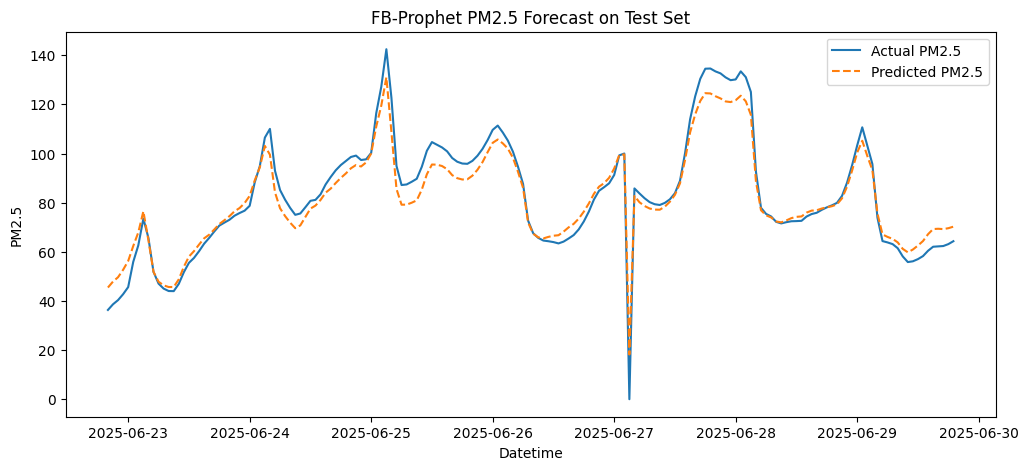

In [ ]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm2_5_model_fbp.predict(df_test)
#forecast_test.columns

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM2.5')
plt.plot(cmp_test.index, cmp_test['yhat'], label='Predicted PM2.5', linestyle='--')
plt.title("FB-Prophet PM2.5 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat']

mae_fbp_pm2_5_test  = mean_absolute_error(y_true, y_pred)
rmse_fbp_pm2_5_test = root_mean_squared_error(y_true, y_pred)
r2_fbp_pm2_5_test   = r2_score(y_true, y_pred)

print(f"FB-Prophet PM2.5 Forecasting Test MAE: {mae_fbp_pm2_5_test:.3f}")
print(f"FB-Prophet PM2.5 Forecasting Test RMSE:{rmse_fbp_pm2_5_test:.3f}")
print(f"FB-Prophet PM2.5 Forecasting Test R²:  {r2_fbp_pm2_5_test:.3f}")

FB-Prophet PM2.5 Forecasting Test MAE: 4.319
FB-Prophet PM2.5 Forecasting Test RMSE:5.449
FB-Prophet PM2.5 Forecasting Test R²:  0.946


# FB Prophet (PM10 Target)

### Prepare Data

In [ ]:
# Load and format data

df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Select features
features = ['pm10', 'pm2_5', 'no', 'no2', 'co', 'so2']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm10': 'y'})

test_hours = 24 * 7
df_train = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

n_total = len(df)

print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_test))

Total: 36830
Train rows: 36662
Test rows:   168
Sum check: 36830


In [ ]:
from sklearn.preprocessing import StandardScaler


# Identify feature columns to scale
feature_cols = [col for col in df_train.columns if col not in ['ds', 'y']]

# Initialize and fit the scaler
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Scale df_test
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

### Model Implemetation

In [ ]:
from prophet import Prophet
import random
random.seed(1234)

# Define regressors
regressors = ['no', 'no2', 'co', 'so2', 'pm2_5']

# Initialize model
pm10_model_fbp = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add external regressors
for reg in regressors:
    pm10_model_fbp.add_regressor(reg)

In [ ]:
# Fit the model
pm10_model_fbp.fit(df_train)

02:25:03 - cmdstanpy - INFO - Chain [1] start processing
02:25:28 - cmdstanpy - INFO - Chain [1] done processing


### Training Results

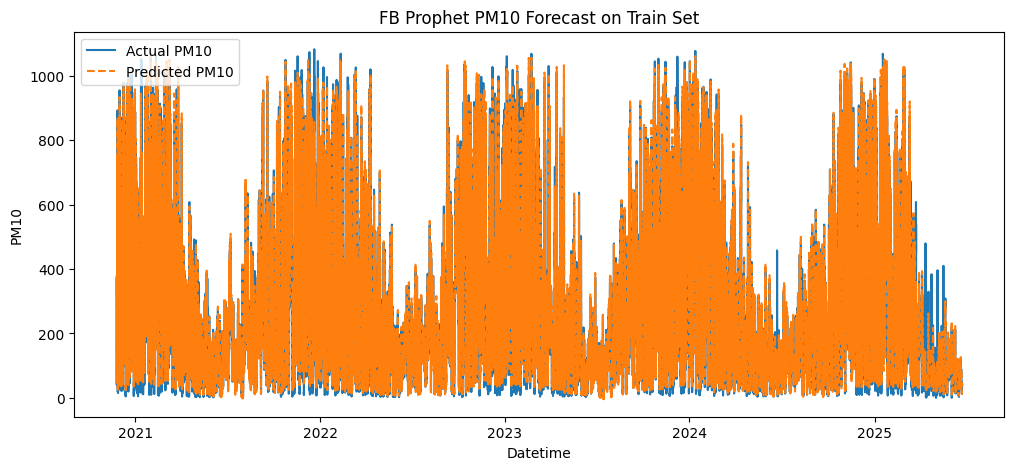

In [ ]:
import matplotlib.pyplot as plt

# 1) Predict on the train set
forecast_train = pm10_model_fbp.predict(df_train)
#forecast_test.columns

# 2) Build two Series indexed by ds
pred = forecast_train.set_index('ds')['yhat']
actual = df_train.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_train = actual.to_frame('y').join(pred.to_frame('yhat'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_train.index, cmp_train['y'],    label='Actual PM10')
plt.plot(cmp_train.index, cmp_train['yhat'], label='Predicted PM10', linestyle='--')
plt.title("FB Prophet PM10 Forecast on Train Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 5) Compute metrics
y_true = cmp_train['y']
y_pred = cmp_train['yhat']

mae_fbp_pm10_train  = mean_absolute_error(y_true, y_pred)
rmse_fbp_pm10_train = root_mean_squared_error(y_true, y_pred)

print(f"FB-Prophet PM10 Forecasting Train MAE:  {mae_fbp_pm10_train:.3f}")
print(f"FB-Prophet PM10 Forecasting Train RMSE: {rmse_fbp_pm10_train:.3f}")

FB-Prophet PM10 Forecasting Train MAE:  14.506
FB-Prophet PM10 Forecasting Train RMSE: 30.290


### Test Results

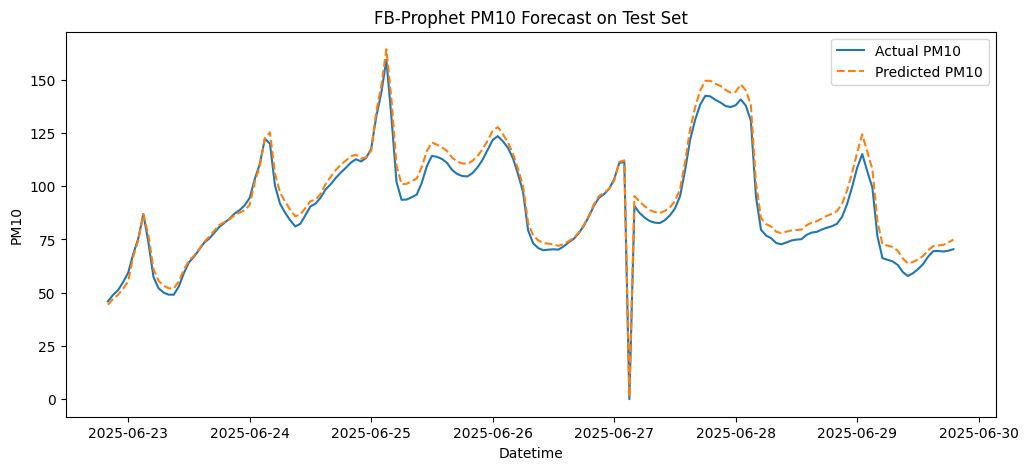

In [ ]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm10_model_fbp.predict(df_test)
#forecast_test.columns

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM10')
plt.plot(cmp_test.index, cmp_test['yhat'], label='Predicted PM10', linestyle='--')
plt.title("FB-Prophet PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat']

mae_fbp_pm10_test  = mean_absolute_error(y_true, y_pred)
rmse_fbp_pm10_test = root_mean_squared_error(y_true, y_pred)
r2_fbp_pm10_test   = r2_score(y_true, y_pred)

print(f"FB-Prophet PM10 Forecasting Test MAE: {mae_fbp_pm10_test:.3f}")
print(f"FB-Prophet PM10 Forecasting Test RMSE:{rmse_fbp_pm10_test:.3f}")
print(f"FB-Prophet PM10 Forecasting Test R²:  {r2_fbp_pm10_test:.3f}")

FB-Prophet PM10 Forecasting Test MAE: 4.002
FB-Prophet PM10 Forecasting Test RMSE:4.633
FB-Prophet PM10 Forecasting Test R²:  0.966


# LightGBM for PM2.5

### Prepare Data

In [2]:
# Load and format data for LightGBM (PM2.5 target)

import pandas as pd

# 1) Load
df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# 2) Select features (target: pm2_5 → 'y')
base_features = ['pm10', 'no', 'no2', 'co', 'so2']  # regressors we’ll use (lags added later)
df = df[['datetime', 'pm2_5'] + base_features].rename(columns={'datetime': 'ds', 'pm2_5': 'y'})

# 3) Hold out the last 7 days for testing
test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test      = df.iloc[-test_hours:].reset_index(drop=True)

# 4) Train/Val split (time-aware; same proportions as your NP setup)
n_total = len(df)
n_val   = int(n_total * 0.1)   # 10% for validation
n_train = n_total - n_val      # rest for training

df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val   = df_train_val.iloc[n_train:].reset_index(drop=True)

# 5) Sanity checks
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))


Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830


### Model Implementation

In [6]:
import lightgbm as lgb
import numpy as np

# Regressors (features for X)
regressors = ['pm10', 'no', 'no2', 'co', 'so2']

# Define train/val/test splits for features & target
X_train, y_train = df_train[regressors], df_train['y']
X_val,   y_val   = df_val[regressors], df_val['y']
X_test,  y_test  = df_test[regressors], df_test['y']

# LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Model parameters (baseline setup, can tune later)
params = {
    "objective": "regression",
    "metric": ["l1", "l2"],   # MAE & RMSE
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
    "verbose": -1
}

callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True)]

pm2_5_model_lgb = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "val"],
    num_boost_round=500,
    callbacks=callbacks
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l1: 14.4041	train's l2: 458.359	val's l1: 21.2448	val's l2: 1007.68


### Results

[LightGBM | PM2.5]  best_iter=57
Train -> MAE: 14.404 | RMSE: 21.409 | R²: 0.985
Val   -> MAE: 21.245 | RMSE: 31.744 | R²: 0.961
Test  -> MAE: 33.405 | RMSE: 38.044 | R²: -1.626


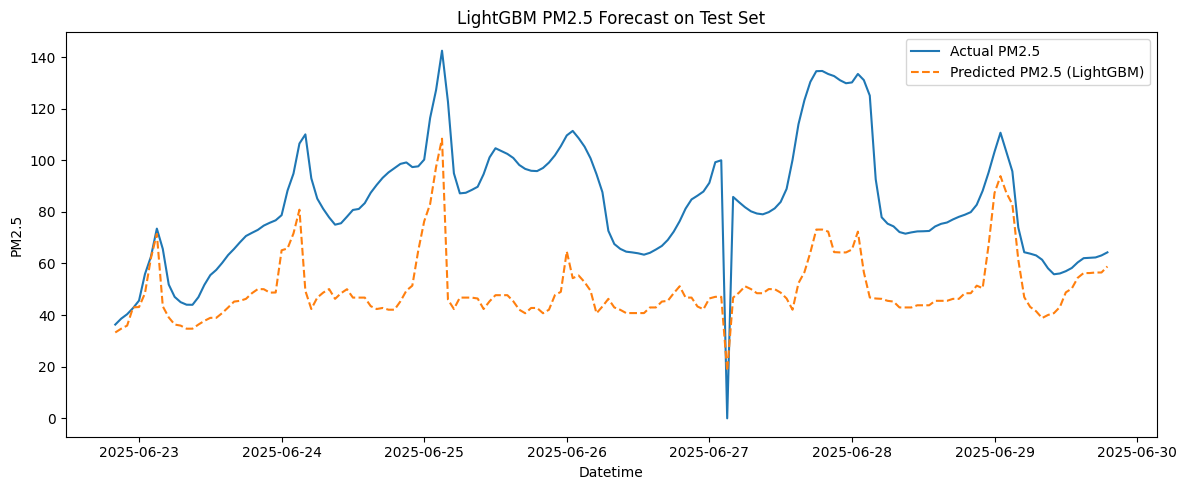

In [10]:
# === Evaluation: predictions + metrics + plots ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Use the best iteration found by early stopping
best_iter = pm2_5_model_lgb.best_iteration

# Predictions
yhat_train = pm2_5_model_lgb.predict(X_train, num_iteration=best_iter)
yhat_val   = pm2_5_model_lgb.predict(X_val,   num_iteration=best_iter)
yhat_test  = pm2_5_model_lgb.predict(X_test,  num_iteration=best_iter)

# Metrics helper
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

# Train metrics
mae_tr  = mean_absolute_error(y_train, yhat_train)
rmse_tr = rmse(y_train, yhat_train)
r2_tr   = r2_score(y_train, yhat_train)

# Val metrics
mae_v  = mean_absolute_error(y_val, yhat_val)
rmse_v = rmse(y_val, yhat_val)
r2_v   = r2_score(y_val, yhat_val)

# Test metrics
mae_te  = mean_absolute_error(y_test, yhat_test)
rmse_te = rmse(y_test, yhat_test)
r2_te   = r2_score(y_test, yhat_test)

print(f"[LightGBM | PM2.5]  best_iter={best_iter}")
print(f"Train -> MAE: {mae_tr:.3f} | RMSE: {rmse_tr:.3f} | R²: {r2_tr:.3f}")
print(f"Val   -> MAE: {mae_v:.3f} | RMSE: {rmse_v:.3f} | R²: {r2_v:.3f}")
print(f"Test  -> MAE: {mae_te:.3f} | RMSE: {rmse_te:.3f} | R²: {r2_te:.3f}")

# Plot: Actual vs Predicted on the test set (aligned to df_test['ds'])
plt.figure(figsize=(12,5))
plt.plot(df_test['ds'], y_test,     label='Actual PM2.5')
plt.plot(df_test['ds'], yhat_test,  label='Predicted PM2.5 (LightGBM)', linestyle='--')
plt.title("LightGBM PM2.5 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()


# LightGBM for PM10

### Prepare Data

In [14]:
# Load and format data for LightGBM (PM10 target)

import pandas as pd

# 1) Load
df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# 2) Select features (target: pm10 → 'y')
base_features = ['pm2_5', 'no', 'no2', 'co', 'so2']  # regressors we’ll use (lags added later)
df = df[['datetime', 'pm10'] + base_features].rename(columns={'datetime': 'ds', 'pm10': 'y'})

# 3) Hold out the last 7 days for testing
test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test      = df.iloc[-test_hours:].reset_index(drop=True)

# 4) Train/Val split (time-aware; same proportions as your NP setup)
n_total = len(df)
n_val   = int(n_total * 0.1)   # 10% for validation
n_train = n_total - n_val      # rest for training

df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val   = df_train_val.iloc[n_train:].reset_index(drop=True)

# 5) Sanity checks
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))


Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830


### Model Implementation

In [15]:
import lightgbm as lgb
import numpy as np

# Regressors (features for X)
regressors = ['pm2_5', 'no', 'no2', 'co', 'so2']

# Define train/val/test splits for features & target
X_train, y_train = df_train[regressors], df_train['y']
X_val,   y_val   = df_val[regressors], df_val['y']
X_test,  y_test  = df_test[regressors], df_test['y']

# LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Model parameters (baseline setup, can tune later)
params = {
    "objective": "regression",
    "metric": ["l1", "l2"],   # MAE & RMSE
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
    "verbose": -1
}

callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True)]

pm10_model_lgb = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "val"],
    num_boost_round=500,
    callbacks=callbacks
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l1: 22.9813	train's l2: 1286.44	val's l1: 52.7069	val's l2: 6025.99


### Results

[LightGBM | PM10]  best_iter=45
Train -> MAE: 22.981 | RMSE: 35.867 | R²: 0.971
Val   -> MAE: 52.707 | RMSE: 77.627 | R²: 0.840
Test  -> MAE: 144.009 | RMSE: 154.463 | R²: -37.297


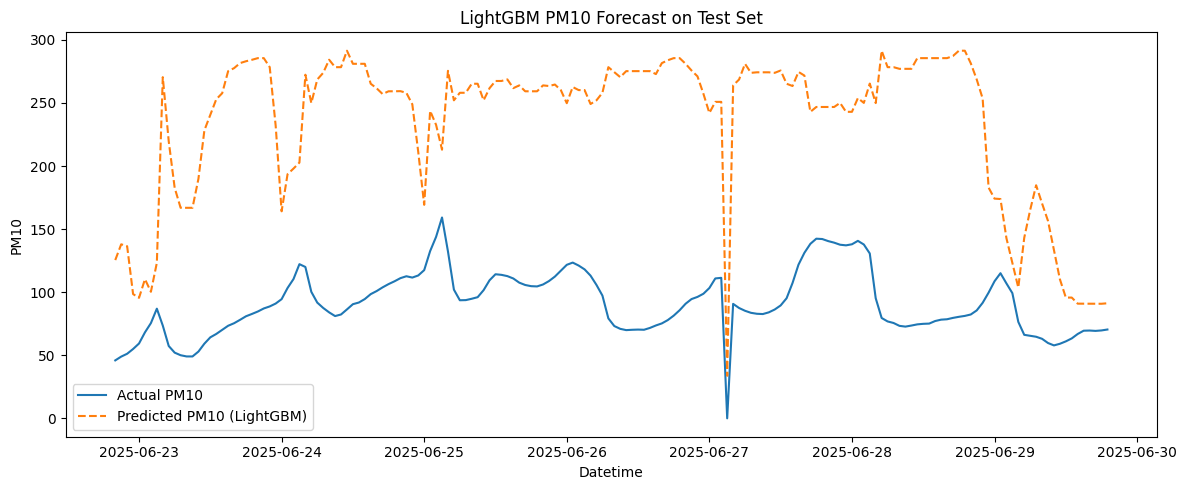

In [18]:
# === Evaluation: predictions + metrics + plots ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Use the best iteration found by early stopping
best_iter = pm10_model_lgb.best_iteration

# Predictions
yhat_train = pm2_5_model_lgb.predict(X_train, num_iteration=best_iter)
yhat_val   = pm2_5_model_lgb.predict(X_val,   num_iteration=best_iter)
yhat_test  = pm2_5_model_lgb.predict(X_test,  num_iteration=best_iter)

# Metrics helper
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

# Train metrics
mae_tr  = mean_absolute_error(y_train, yhat_train)
rmse_tr = rmse(y_train, yhat_train)
r2_tr   = r2_score(y_train, yhat_train)

# Val metrics
mae_v  = mean_absolute_error(y_val, yhat_val)
rmse_v = rmse(y_val, yhat_val)
r2_v   = r2_score(y_val, yhat_val)

# Test metrics
mae_te  = mean_absolute_error(y_test, yhat_test)
rmse_te = rmse(y_test, yhat_test)
r2_te   = r2_score(y_test, yhat_test)

print(f"[LightGBM | PM10]  best_iter={best_iter}")
print(f"Train -> MAE: {mae_tr:.3f} | RMSE: {rmse_tr:.3f} | R²: {r2_tr:.3f}")
print(f"Val   -> MAE: {mae_v:.3f} | RMSE: {rmse_v:.3f} | R²: {r2_v:.3f}")
print(f"Test  -> MAE: {mae_te:.3f} | RMSE: {rmse_te:.3f} | R²: {r2_te:.3f}")

# Plot: Actual vs Predicted on the test set (aligned to df_test['ds'])
plt.figure(figsize=(12,5))
plt.plot(df_test['ds'], y_test,     label='Actual PM10')
plt.plot(df_test['ds'], yhat_test,  label='Predicted PM10 (LightGBM)', linestyle='--')
plt.title("LightGBM PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.tight_layout()
plt.show()


# LSTM for PM 2.5

### Prepare Data

In [26]:
# LSTM | Cell 1: Load, split, scale (X only), and windowed sequences

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ---- 1) Load & basic formatting (PM2.5 as target 'y') ----
df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

regressors = ['pm10', 'no', 'no2', 'co', 'so2']  # same as NP
df = df[['datetime', 'pm2_5'] + regressors].rename(columns={'datetime': 'ds', 'pm2_5': 'y'})

# ---- 2) Time-aware split: last 7 days as test; 10% val (like NP) ----
test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test      = df.iloc[-test_hours:].reset_index(drop=True)

n_total = len(df)
n_val   = int(n_total * 0.1)
n_train = n_total - n_val

df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val   = df_train_val.iloc[n_train:].reset_index(drop=True)

print("Total:", len(df))
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))

# ---- 3) Scale regressors ONLY (targets left unscaled for interpretable metrics) ----
scaler_X = StandardScaler()
X_train_raw = df_train[regressors].values
X_val_raw   = df_val[regressors].values
X_test_raw  = df_test[regressors].values

X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

y_train = df_train['y'].values
y_val   = df_val['y'].values
y_test  = df_test['y'].values

# ---- 4) Make supervised windowed sequences (7 lags → next-hour forecast) ----
def make_windowed(X, y, window=7, horizon=1):
    """
    Build samples of shape (n_samples, window, n_features) predicting y[t + horizon - 1].
    No leakage across splits; each split is windowed independently.
    """
    Xs, ys = [], []
    for t in range(len(X) - window - horizon + 1):
        Xs.append(X[t:t+window])
        ys.append(y[t+window + horizon - 1])
    return np.asarray(Xs), np.asarray(ys)

WINDOW = 24
HORIZON = 1

Xtr_seq, ytr_seq = make_windowed(X_train, y_train, WINDOW, HORIZON)
Xv_seq,  yv_seq  = make_windowed(X_val,   y_val,   WINDOW, HORIZON)
Xte_seq, yte_seq = make_windowed(X_test,  y_test,  WINDOW, HORIZON)

print("Xtr_seq:", Xtr_seq.shape, "Xv_seq:", Xv_seq.shape, "Xte_seq:", Xte_seq.shape)



Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830
Xtr_seq: (33123, 24, 5) Xv_seq: (3491, 24, 5) Xte_seq: (144, 24, 5)


### Model Implementaiton

In [27]:
# LSTM | Cell 2: Define, compile, train with early stopping

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(42)

n_features = Xtr_seq.shape[-1]

model_lstm = models.Sequential([
    layers.Input(shape=(WINDOW, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mae',  # robust for scale; we’ll report MAE/RMSE/R² separately
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model_lstm.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xv_seq, yv_seq),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

print("Best val MAE:", np.min(history.history["val_loss"]))


Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 164.4627 - val_loss: 96.1988
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 130.9360 - val_loss: 95.3989
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 94.4498 - val_loss: 63.1299
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 60.1018 - val_loss: 47.9973
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 44.1937 - val_loss: 37.9335
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 36.8340 - val_loss: 32.0902
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 33.4021 - val_loss: 30.3750
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 31.4140 - val_loss: 29.1863
Epoch 9/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 30.6166 - val_loss: 28.9808
Epoch 10/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 29.8231 - val_loss: 28.4799
Epoch 11/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 29.3872 - val_loss: 28.9307
Epoch 12/50
130/1

### Results

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[LSTM | PM2.5] window=24, horizon=1
Train -> MAE: 26.779 | RMSE: 49.715 | R²: 0.920
Val   -> MAE: 28.480 | RMSE: 49.574 | R²: 0.905
Test  -> MAE: 38.829 | RMSE: 40.049 | R²: -2.491
144 144


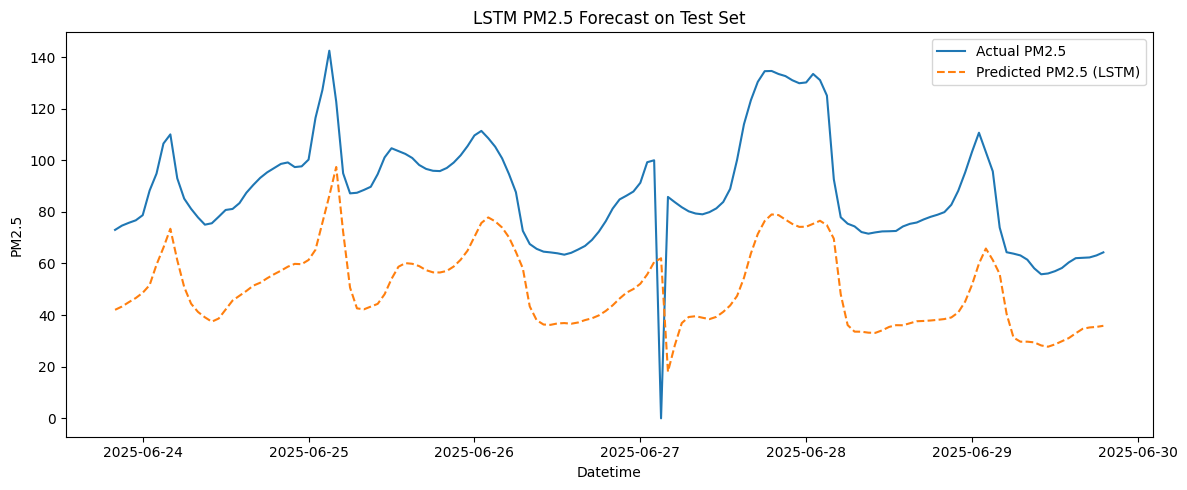

In [28]:
# LSTM | Cell 3: Evaluation & Plot

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Predictions
yhat_tr = model_lstm.predict(Xtr_seq).ravel()
yhat_v  = model_lstm.predict(Xv_seq).ravel()
yhat_te = model_lstm.predict(Xte_seq).ravel()

# Metrics helpers
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

# Train metrics
mae_tr  = mean_absolute_error(ytr_seq, yhat_tr)
rmse_tr = rmse(ytr_seq, yhat_tr)
r2_tr   = r2_score(ytr_seq, yhat_tr)

# Val metrics
mae_v  = mean_absolute_error(yv_seq, yhat_v)
rmse_v = rmse(yv_seq, yhat_v)
r2_v   = r2_score(yv_seq, yhat_v)

# Test metrics
mae_te  = mean_absolute_error(yte_seq, yhat_te)
rmse_te = rmse(yte_seq, yhat_te)
r2_te   = r2_score(yte_seq, yhat_te)

print(f"[LSTM | PM2.5] window={WINDOW}, horizon={HORIZON}")
print(f"Train -> MAE: {mae_tr:.3f} | RMSE: {rmse_tr:.3f} | R²: {r2_tr:.3f}")
print(f"Val   -> MAE: {mae_v:.3f} | RMSE: {rmse_v:.3f} | R²: {r2_v:.3f}")
print(f"Test  -> MAE: {mae_te:.3f} | RMSE: {rmse_te:.3f} | R²: {r2_te:.3f}")

# Align timestamps with windowed test samples
n_te = len(yte_seq)  # after windowing
start_idx = WINDOW + HORIZON - 1
end_idx   = start_idx + n_te

ds_test_seq = df_test['ds'].iloc[start_idx:end_idx].reset_index(drop=True)

print(len(ds_test_seq), len(yte_seq))  # should match


# Plot test Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(ds_test_seq, yte_seq,   label='Actual PM2.5')
plt.plot(ds_test_seq, yhat_te,   label='Predicted PM2.5 (LSTM)', linestyle='--')
plt.title("LSTM PM2.5 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()


# LSTM for PM 10

### Prepare Data

In [29]:
# LSTM (PM10) | Cell 1: Load, split, scale (X only), and windowed sequences

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ---- 1) Load & basic formatting (PM10 as target 'y') ----
df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Regressors for PM10 (mirror your feature selection)
regressors = ['pm2_5', 'no', 'no2', 'co', 'so2']
df = df[['datetime', 'pm10'] + regressors].rename(columns={'datetime': 'ds', 'pm10': 'y'})

# ---- 2) Time-aware split: last 7 days as test; 10% val (same as NP) ----
test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test      = df.iloc[-test_hours:].reset_index(drop=True)

n_total = len(df)
n_val   = int(n_total * 0.1)
n_train = n_total - n_val

df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val   = df_train_val.iloc[n_train:].reset_index(drop=True)

print("Total:", len(df))
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows: ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))

# ---- 3) Scale regressors ONLY (targets unscaled) ----
scaler_X = StandardScaler()
X_train_raw = df_train[regressors].values
X_val_raw   = df_val[regressors].values
X_test_raw  = df_test[regressors].values

X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

y_train = df_train['y'].values
y_val   = df_val['y'].values
y_test  = df_test['y'].values

# ---- 4) Build supervised windowed sequences (7 lags → next-hour forecast) ----
def make_windowed(X, y, window=7, horizon=1):
    Xs, ys = [], []
    for t in range(len(X) - window - horizon + 1):
        Xs.append(X[t:t+window])
        ys.append(y[t+window + horizon - 1])
    return np.asarray(Xs), np.asarray(ys)

WINDOW  = 24
HORIZON = 1

Xtr_seq, ytr_seq = make_windowed(X_train, y_train, WINDOW, HORIZON)
Xv_seq,  yv_seq  = make_windowed(X_val,   y_val,   WINDOW, HORIZON)
Xte_seq, yte_seq = make_windowed(X_test,  y_test,  WINDOW, HORIZON)

print("Xtr_seq:", Xtr_seq.shape, "Xv_seq:", Xv_seq.shape, "Xte_seq:", Xte_seq.shape)


Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:  168
Sum check: 36830
Xtr_seq: (33123, 24, 5) Xv_seq: (3491, 24, 5) Xte_seq: (144, 24, 5)


### Model Implementation

In [31]:
# LSTM (PM10) | Cell 2: Define, compile, train with early stopping

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(42)

n_features = Xtr_seq.shape[-1]

model_lstm_pm10 = models.Sequential([
    layers.Input(shape=(WINDOW, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_lstm_pm10.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mae',
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_pm10 = model_lstm_pm10.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xv_seq, yv_seq),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

print("Best val MAE (PM10):", np.min(history_pm10.history["val_loss"]))


Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 213.2960 - val_loss: 127.9782
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 169.9165 - val_loss: 125.1873
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 150.0199 - val_loss: 101.0411
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 104.8230 - val_loss: 80.4444
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 71.6559 - val_loss: 63.4215
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 54.3936 - val_loss: 53.2887
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 45.3870 - val_loss: 46.9851
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 40.6916 - val_loss: 41.4046
Epoch 9/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 38.0017 - val_loss: 37.7189
Epoch 10/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 36.3622 - val_loss: 36.5292
Epoch 11/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 35.5219 - val_loss: 34.8035
Epoch 12/50


### Results

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[LSTM | PM10] window=24, horizon=1
Train -> MAE: 26.381 | RMSE: 55.266 | R²: 0.932
Val   -> MAE: 26.562 | RMSE: 57.264 | R²: 0.913
Test  -> MAE: 10.577 | RMSE: 17.638 | R²: 0.439
144 144


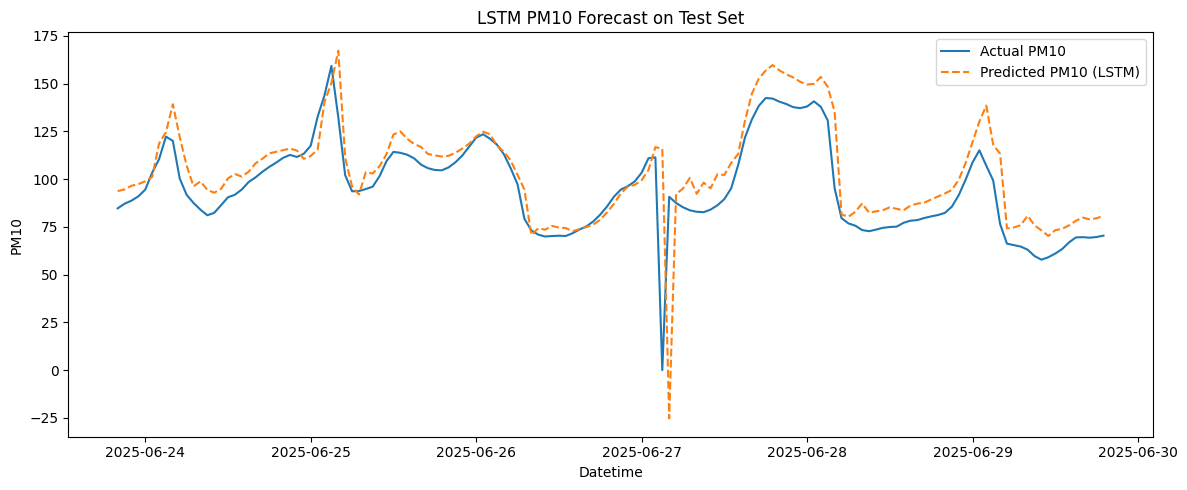

In [33]:
# LSTM (PM10) | Cell 3: Evaluation & Plot

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Predictions
yhat_tr = model_lstm_pm10.predict(Xtr_seq).ravel()
yhat_v  = model_lstm_pm10.predict(Xv_seq).ravel()
yhat_te = model_lstm_pm10.predict(Xte_seq).ravel()

# Metrics helpers
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

# Train metrics
mae_tr  = mean_absolute_error(ytr_seq, yhat_tr)
rmse_tr = rmse(ytr_seq, yhat_tr)
r2_tr   = r2_score(ytr_seq, yhat_tr)

# Val metrics
mae_v  = mean_absolute_error(yv_seq, yhat_v)
rmse_v = rmse(yv_seq, yhat_v)
r2_v   = r2_score(yv_seq, yhat_v)

# Test metrics
mae_te  = mean_absolute_error(yte_seq, yhat_te)
rmse_te = rmse(yte_seq, yhat_te)
r2_te   = r2_score(yte_seq, yhat_te)

print(f"[LSTM | PM10] window={WINDOW}, horizon={HORIZON}")
print(f"Train -> MAE: {mae_tr:.3f} | RMSE: {rmse_tr:.3f} | R²: {r2_tr:.3f}")
print(f"Val   -> MAE: {mae_v:.3f} | RMSE: {rmse_v:.3f} | R²: {r2_v:.3f}")
print(f"Test  -> MAE: {mae_te:.3f} | RMSE: {rmse_te:.3f} | R²: {r2_te:.3f}")

# ---- Align timestamps with windowed test samples (fix off-by-one) ----
n_te = len(yte_seq)                # after windowing
start_idx = WINDOW + HORIZON - 1   # first aligned timestamp
end_idx   = start_idx + n_te
ds_test_seq = df_test['ds'].iloc[start_idx:end_idx].reset_index(drop=True)
print(len(ds_test_seq), len(yte_seq))  # should match

# Plot
plt.figure(figsize=(12,5))
plt.plot(ds_test_seq, yte_seq,  label='Actual PM10')
plt.plot(ds_test_seq, yhat_te,  label='Predicted PM10 (LSTM)', linestyle='--')
plt.title("LSTM PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.tight_layout()
plt.show()


# Results

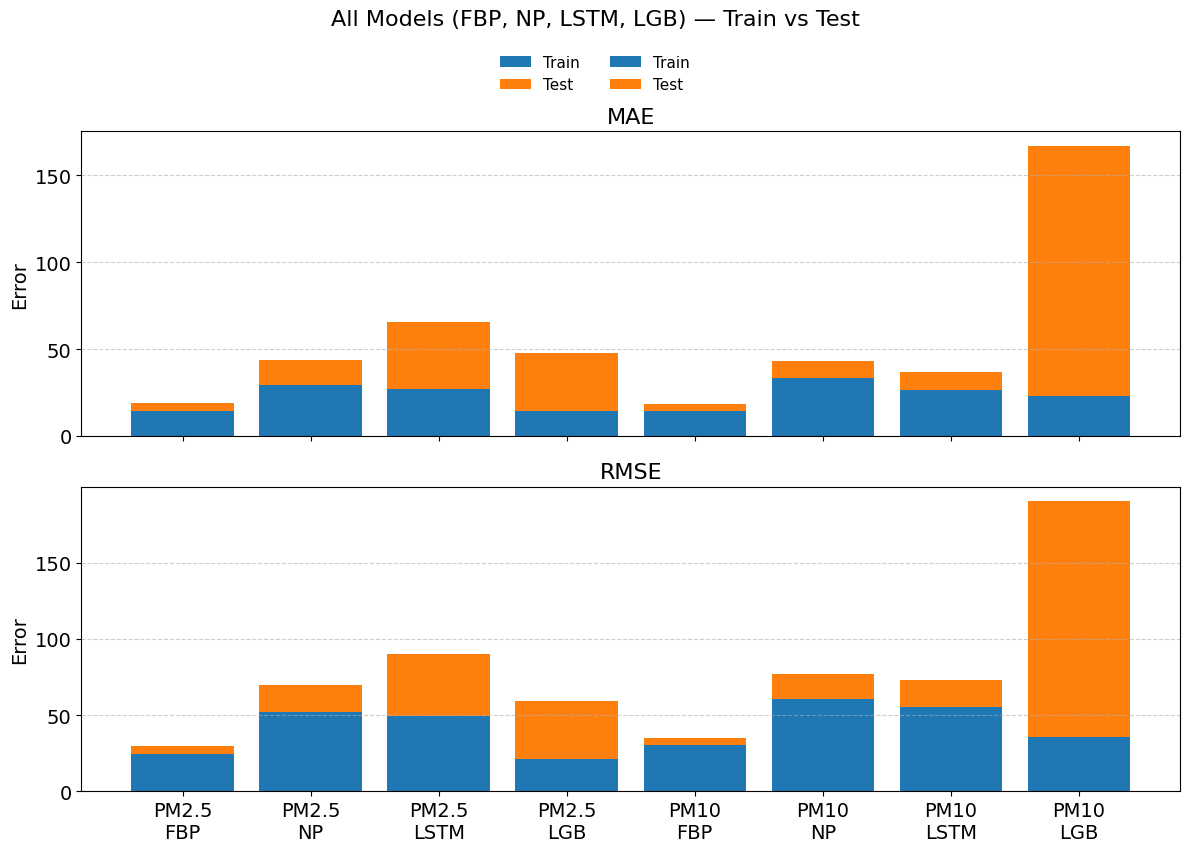

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Fill with metrics for all models (keys can stay as full names) ----
train_metrics = {
    "PM2.5": {
        "FB Prophet":     {"MAE": 14.40, "RMSE": 24.60},
        "NeuralProphet":  {"MAE": 29.19, "RMSE": 51.98},
        "LSTM":           {"MAE": 26.78, "RMSE": 49.72},
        "LightGBM":       {"MAE": 14.40, "RMSE": 21.41},
    },
    "PM10": {
        "FB Prophet":     {"MAE": 14.50, "RMSE": 30.30},
        "NeuralProphet":  {"MAE": 33.28, "RMSE": 60.64},
        "LSTM":           {"MAE": 26.38, "RMSE": 55.27},
        "LightGBM":       {"MAE": 22.98, "RMSE": 35.87},
    }
}

test_metrics = {
    "PM2.5": {
        "FB Prophet":     {"MAE": 4.30,  "RMSE": 5.40},
        "NeuralProphet":  {"MAE": 14.60, "RMSE": 17.80},
        "LSTM":           {"MAE": 38.83, "RMSE": 40.05},
        "LightGBM":       {"MAE": 33.41, "RMSE": 38.04},
    },
    "PM10": {
        "FB Prophet":     {"MAE": 4.00,  "RMSE": 4.63},
        "NeuralProphet":  {"MAE": 10.00, "RMSE": 16.10},
        "LSTM":           {"MAE": 10.58, "RMSE": 17.64},
        "LightGBM":       {"MAE": 144.01,"RMSE": 154.46},
    }
}

def stacked_comparison_vertical(train_metrics, test_metrics, title="Train/Test Stacked Comparison (All Models)"):
    # Abbreviation map for model labels on x-axis
    model_abbrev = {
        "FB Prophet": "FBP",
        "NeuralProphet": "NP",
        "LSTM": "LSTM",
        "LightGBM": "LGB"
    }

    pollutants = list(train_metrics.keys())
    models_order = ["FB Prophet", "NeuralProphet", "LSTM", "LightGBM"]

    def collect(metric, source):
        vals, labels = [], []
        for p in pollutants:
            for m in models_order:
                vals.append(source[p][m][metric])
                labels.append(f"{p}\n{model_abbrev.get(m, m)}")
        return np.array(vals), labels

    train_mae, labels = collect("MAE", train_metrics)
    test_mae, _       = collect("MAE", test_metrics)
    train_rmse, _     = collect("RMSE", train_metrics)
    test_rmse, _      = collect("RMSE", test_metrics)

    x = np.arange(len(labels))

    fig, (ax_mae, ax_rmse) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # ---- MAE subplot ----
    ax_mae.bar(x, train_mae, label="Train")
    ax_mae.bar(x, test_mae, bottom=train_mae, label="Test")
    ax_mae.set_title("MAE", fontsize=16)
    ax_mae.set_ylabel("Error", fontsize=14)
    ax_mae.tick_params(axis="both", labelsize=14)
    ax_mae.grid(axis="y", linestyle="--", alpha=0.6)

    # ---- RMSE subplot ----
    ax_rmse.bar(x, train_rmse, label="Train")
    ax_rmse.bar(x, test_rmse,  bottom=train_rmse, label="Test")
    ax_rmse.set_title("RMSE", fontsize=16)
    ax_rmse.set_ylabel("Error", fontsize=14)
    ax_rmse.set_xticks(x)
    ax_rmse.set_xticklabels(labels, fontsize=14)
    ax_rmse.tick_params(axis="both", labelsize=14)
    ax_rmse.grid(axis="y", linestyle="--", alpha=0.6)

    # Legend + main title
    fig.legend(loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02), fontsize=11)
    fig.suptitle(title, y=1.06, fontsize=16)

    plt.tight_layout()
    plt.show()

# Run
stacked_comparison_vertical(train_metrics, test_metrics,
                            title="All Models (FBP, NP, LSTM, LGB) — Train vs Test")
